# Google Colab Lab Assignment 5.1 - Forecasting using LSTM

**Course Name:** PEC Deep Learning

**Lab Title:** To forecast future values of a univariate time series using LSTM-based models.

**Student Name:** Suraj Sanjay Didwagh

**Student ID:** 202201040126

**Date of Submission:** 10/04/2025

**Group Members**:
1. Shriram Savant
2. Prathamesh Galugade
3. Punit Kawadkar


**Objective**
This project aims to forecast future values of a univariate time series—specifically the “Units Sold” attribute from a retail inventory dataset—using LSTM-based models.




## Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(42)


## Data Loading and Exploration

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TY/Deep Learning/Lab Assignment 5.1/retail_store_inventory.csv')

# Display the basic information
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
# Filter for a single store and product
store_id = "S001"
product_id = "P0001"
df_filtered = df[(df['Store ID'] == store_id) & (df['Product ID'] == product_id)].copy()

# Ensure the Date column is in datetime format, sort by date, and drop missing values
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
df_filtered.sort_values(by='Date', inplace=True)
df_filtered.dropna(inplace=True)


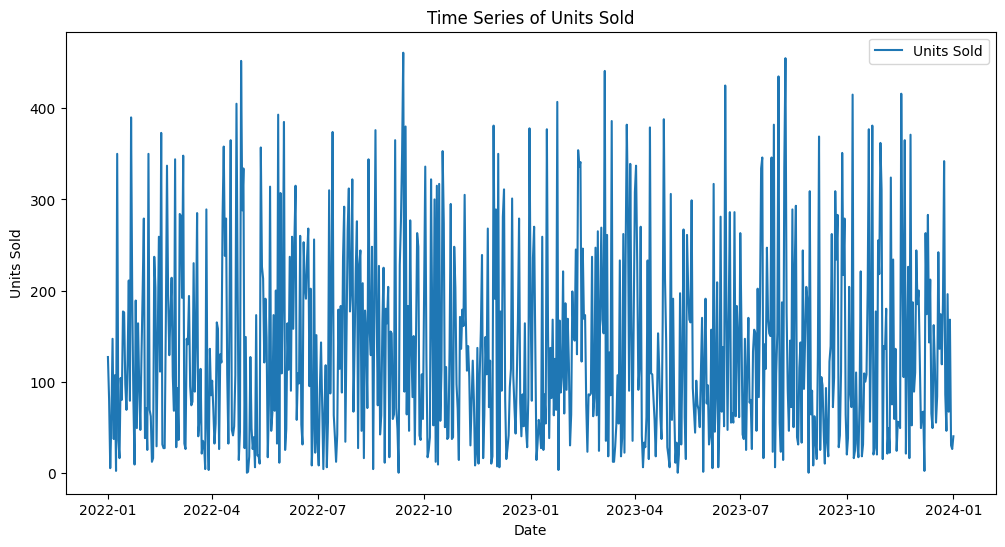

In [ ]:
# Use the filtered data for a specific product
time_series = df_filtered[['Date', 'Units Sold']].copy()
time_series.set_index('Date', inplace=True)

# Visualize the time series
plt.figure(figsize=(12,6))
plt.plot(time_series.index, time_series['Units Sold'], label='Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Time Series of Units Sold')
plt.legend()
plt.show()


## Data Normalization

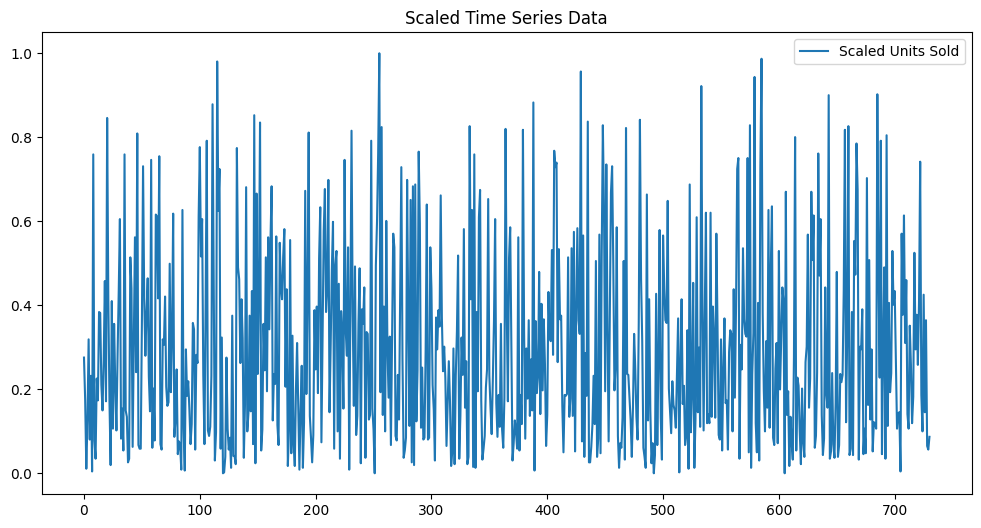

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series)

# Plot a sample of scaled data
plt.figure(figsize=(12,6))
plt.plot(scaled_data, label='Scaled Units Sold')
plt.title('Scaled Time Series Data')
plt.legend()
plt.show()


## Create Sequences with Window Size 60

In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Reshape input for LSTM: (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (671, 60, 1)
Shape of y: (671,)


## Split Data into Training and Testing Sets

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (536, 60, 1)
Shape of X_test: (135, 60, 1)


## Build and Train the Standard LSTM Model

In [ ]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
lstm_model.summary()

# Define callbacks: EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
mc = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = lstm_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_split=0.1,
                              callbacks=[es, mc],
                              verbose=1)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1128
Epoch 1: val_loss improved from inf to 0.06490, saving model to best_lstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1111 - val_loss: 0.0649
Epoch 2/50
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0662
Epoch 2: val_loss improved from 0.06490 to 0.06105, saving model to best_lstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0651 - val_loss: 0.0611
Epoch 3/50
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0611
Epoch 3: val_loss did not improve from 0.06105
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0606 - val_loss: 0.0614
Epoch 4/50
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0581
Epoch 4: val_loss did not improve from 0.06105
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0579 - val_loss: 0.0616
Epoch 5/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0593
Epoch 5: val_loss did not improve from 0.06105
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0590 - val_loss: 0.0613
Epoch 6/50
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0593
Epoch 6: val_loss did not improve from 0.06105
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0590 - val_loss: 0.0623
Epoch 7/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0537
Epoch 7: val_loss improved from 0.06105 to 0.06102, saving model to best_lstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0541 - val_loss: 0.0610
Epoch 8/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0613
Epoch 8: val_loss did not improve from 0.06102
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0611 - val_loss: 0.0657
Epoch 9/50
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0526
Epoch 9: val_loss improved from 0.06102 to 0.06076, saving model to best_lstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0537 - val_loss: 0.0608
Epoch 10/50
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0554
Epoch 10: val_loss did not improve from 0.06076
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0559 - val_loss: 0.0614
Epoch 11/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0539
Epoch 11: val_loss did not improve from 0.06076
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0542 - val_loss: 0.0613
Epoch 12/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0542
Epoch 12: val_loss did not improve from 0.06076
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0546 - val_loss: 0.0613
Epoch 13/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0581
Epoch 13: val_loss did not improve from 0.06076
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0581 - val_loss: 0.0611
Epoch 14/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0575
Epoch 14: val_loss did not improve from 0.06076
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0574 - val

## Evaluate and Plot Predictions for LSTM Model

In [ ]:
# LSTM Predictions on test data
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform predictions and true values
lstm_predictions_inv = scaler.inverse_transform(lstm_predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [ ]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_predictions_inv))
lstm_mae = mean_absolute_error(y_test_inv, lstm_predictions_inv)
print(f"LSTM Test RMSE: {lstm_rmse:.2f}")
print(f"LSTM Test MAE: {lstm_mae:.2f}")


LSTM Test RMSE: 108.84
LSTM Test MAE: 91.49


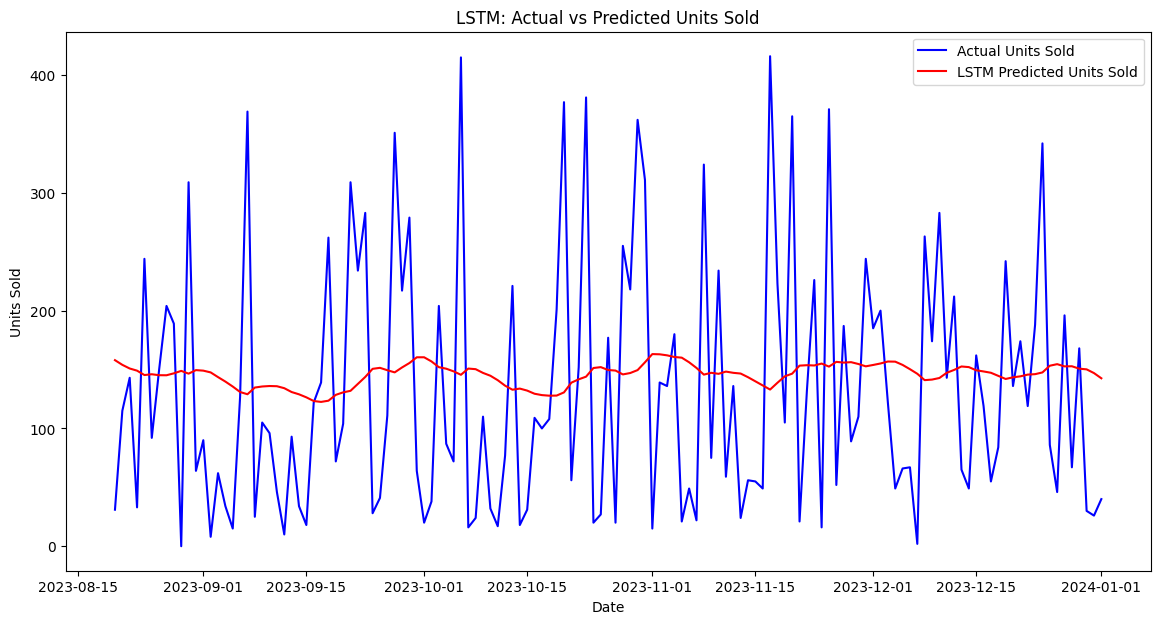

In [ ]:
# Get the date index for plotting the test set
test_dates = time_series.index[-len(y_test_inv):]

plt.figure(figsize=(14,7))
plt.plot(test_dates, y_test_inv, color='blue', label='Actual Units Sold')
plt.plot(test_dates, lstm_predictions_inv, color='red', label='LSTM Predicted Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('LSTM: Actual vs Predicted Units Sold')
plt.legend()
plt.show()


## Build and Train a Bidirectional LSTM (BiLSTM) Model

In [ ]:
# Define the Bidirectional LSTM model
bilstm_model = Sequential()
# First layer: Bidirectional LSTM with dropout
bilstm_model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
bilstm_model.add(Dropout(0.2))
# Second layer: Standard LSTM
bilstm_model.add(LSTM(units=50, return_sequences=False))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer='adam', loss='mean_squared_error')
bilstm_model.summary()

# Callbacks: EarlyStopping and ModelCheckpoint for BiLSTM
es_bi = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
mc_bi = ModelCheckpoint('best_bilstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 60, 100)        │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_bilstm = bilstm_model.fit(X_train, y_train,
                                  epochs=50,
                                  batch_size=32,
                                  validation_split=0.1,
                                  callbacks=[es_bi, mc_bi],
                                  verbose=1)


Epoch 1/50
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0964
Epoch 1: val_loss improved from inf to 0.06292, saving model to best_bilstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0910 - val_loss: 0.0629
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0572
Epoch 2: val_loss improved from 0.06292 to 0.06266, saving model to best_bilstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0573 - val_loss: 0.0627
Epoch 3/50
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0587
Epoch 3: val_loss improved from 0.06266 to 0.06215, saving model to best_bilstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0589 - val_loss: 0.0622
Epoch 4/50
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0556
Epoch 4: val_loss did not improve from 0.06215
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0565 - val_loss: 0.0623
Epoch 5/50
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0592
Epoch 5: val_loss improved from 0.06215 to 0.06181, saving model to best_bilstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0583 - val_loss: 0.0618
Epoch 6/50
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0589
Epoch 6: val_loss did not improve from 0.06181
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0582 - val_loss: 0.0626
Epoch 7/50
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0550
Epoch 7: val_loss did not improve from 0.06181
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0558 - val_loss: 0.0620
Epoch 8/50
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0585
Epoch 8: val_loss did not improve from 0.06181
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0579 - val_loss: 0.0628
Epoch 9/50
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0536
Epoch 9: val_loss improved from 0.06181 to 0.06128, saving model to best_bilstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0547 - val_loss: 0.0613
Epoch 10/50
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0541
Epoch 10: val_loss did not improve from 0.06128
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0548 - val_loss: 0.0620
Epoch 11/50
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0535
Epoch 11: val_loss improved from 0.06128 to 0.06069, saving model to best_bilstm_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0551 - val_loss: 0.0607
Epoch 12/50
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0557
Epoch 12: val_loss did not improve from 0.06069
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0563 - val_loss: 0.0607
Epoch 13/50
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0621
Epoch 13: val_loss did not improve from 0.06069
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0608 - val_loss: 0.0637
Epoch 14/50
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0592
Epoch 14: val_loss did not improve from 0.06069
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0588 - val_loss: 0.0633
Epoch 15/50
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0617
Epoch 15: val_loss did not improve from 0.06069
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0603 - val_loss: 0.0609
Epoch 16/50
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0608
Epoch 16: val_loss did not improve from 0.06069
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0603 

## Evaluate and Plot Predictions for BiLSTM Model

In [ ]:
# BiLSTM Predictions on test data
bilstm_predictions = bilstm_model.predict(X_test)

# Inverse transform predictions and the true values
bilstm_predictions_inv = scaler.inverse_transform(bilstm_predictions)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [ ]:
bilstm_rmse = np.sqrt(mean_squared_error(y_test_inv, bilstm_predictions_inv))
bilstm_mae = mean_absolute_error(y_test_inv, bilstm_predictions_inv)
print(f"BiLSTM Test RMSE: {bilstm_rmse:.2f}")
print(f"BiLSTM Test MAE: {bilstm_mae:.2f}")


BiLSTM Test RMSE: 108.60
BiLSTM Test MAE: 92.23


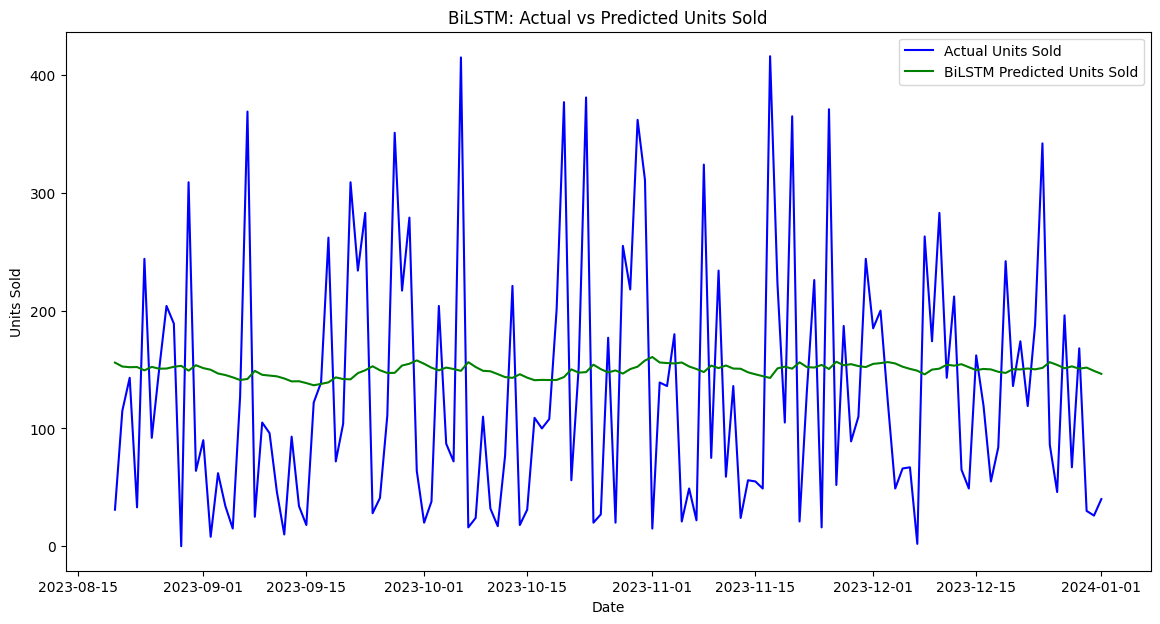

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(test_dates, y_test_inv, color='blue', label='Actual Units Sold')
plt.plot(test_dates, bilstm_predictions_inv, color='green', label='BiLSTM Predicted Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('BiLSTM: Actual vs Predicted Units Sold')
plt.legend()
plt.show()


### **Declaration**

I,Suraj Didwaghr, confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link:  https://github.com/surajdidwagh/Lab-Assignment-5.1---Demand-Forecasting-in-Supply-Chain-Management.git

Signature: Suraj Didwagh